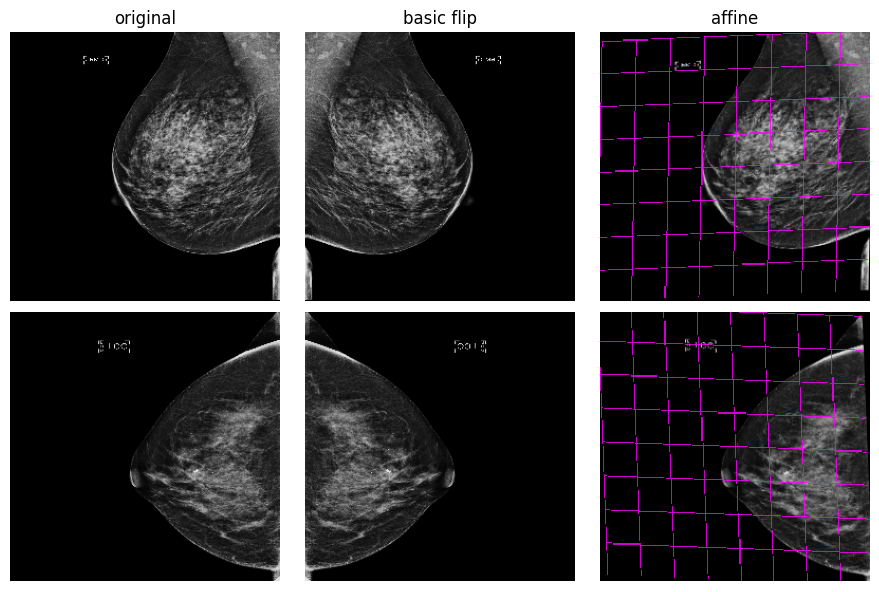

In [11]:
# Cell: visualise real-sample + two augmentations
import random, glob, os, nibabel as nib, numpy as np
import matplotlib.pyplot as plt
import monai.transforms as mt
from PIL import Image

# ---------- config --------------------------------------------------
ROOT_REAL = "/mnt/d/Datasets/EMBED/EMBED_binary_256x256/train/original"
SEED      = 123                     # change → new augment seeds
RES       = 256

# ---------- helpers -------------------------------------------------
def load_slice(path):
    """Load first slice of a NIfTI file → numpy (H,W) in [0,1]."""
    arr = nib.load(path).get_fdata().astype(np.float32)
    if arr.ndim == 3:
        arr = arr[..., 0]
    arr = (arr - arr.min()) / (arr.ptp() + 1e-8)
    return arr

def to_pil(arr):
    return Image.fromarray((arr * 255).astype(np.uint8), mode="L")
    
def make_lattice(res=256, step=32, line=2):
    """Return (H,W) numpy array with thin white lines every `step` px."""
    g = np.zeros((res, res), np.float32)
    g[::step, :] = 1
    g[:, ::step] = 1
    if line > 1:                       # optional thickness
        for i in range(1, line):
            g[i::step, :] = 1
            g[:, i::step] = 1
    return g

# --- config, helpers, make_lattice identical ----------------------

basic_tf = mt.Compose([
    mt.RandFlipd(keys=["img"], prob=1.0, spatial_axis=1),  # ← key "img"
])

geom_tf = mt.Compose([
    mt.RandAffined(
        keys=["img", "grid"],               # same key set
        prob=1.0,
        rotate_range=[0, 0, np.pi/12],
        shear_range=[0.1, 0.1],
        translate_range=[0.05, 0.05],
        scale_range=[0.05, 0.05],
        mode=("bilinear", "nearest"),
        padding_mode="zeros",
    )
])



# ---------- pick one sample per class ------------------------------
random.seed(SEED)
slices = {}
for cls in ["benign", "malignant"]:
    paths = glob.glob(os.path.join(ROOT_REAL, cls, "*", "slice.nii.gz"))
    assert paths, f"no slices in {cls}"
    slices[cls] = random.choice(paths)

# ---------- visualise ----------------------------------------------

fig, axes = plt.subplots(len(slices), 3, figsize=(9, 6))
titles = ["original", "basic flip", "affine"]

for row, (cls, path) in enumerate(slices.items()):
    img_np = load_slice(path)                # (H,W) in [0,1]
    lat_np = make_lattice(RES)

    # build channel-first tensors for MONAI
    base = {"img": img_np[None], "grid": lat_np[None]}

    basic = basic_tf({"img": img_np[None]})["img"][0]
    out   = geom_tf(base)
    geom, grid = out["img"][0], out["grid"][0]

    panels = [(img_np, None), (basic, None), (geom, grid)]
    for col, (slice_, overlay) in enumerate(panels):
        ax = axes[row, col]
        ax.imshow(slice_, cmap="gray", vmin=0, vmax=1)
    
        # overlay only where grid==1  (makes background fully transparent)
        if overlay is not None:
            mask = np.ma.masked_where(overlay == 0, overlay)     # hide zeros
            ax.imshow(mask, cmap="spring", alpha=0.8)
    
        ax.set_xlim(0, RES); ax.set_ylim(RES, 0); ax.set_aspect("equal")
        ax.axis("off")
        if row == 0:
            ax.set_title(titles[col], fontsize=12)

    axes[row, 0].set_ylabel(cls, rotation=90, fontsize=12)

plt.tight_layout()
plt.show()
